### Set up

In [1]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
import pandas as pd
from wordcloud import WordCloud
import collections 
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
import matplotlib
import time

from sklearn.svm import SVC
from sklearn.svm import LinearSVC

from sklearn.preprocessing import StandardScaler
from sklearn import cross_validation
from sklearn.cluster import KMeans
import sklearn.linear_model as skl_lm
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import average_precision_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import TruncatedSVD
plt.style.use('ggplot')

/Users/alice/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
data = pickle.load(open("All_email.txt","rb"))

### Seperate to training /test data

In [3]:
#Seperate to training data/test data
train, test = train_test_split(data, test_size = 0.3, random_state=0)

### Plots

In [4]:
year_count = []
for i in ['1999','2000','2001','2002','2003','2004','2005','2006','2007']:
          c=collections.Counter(data[data['Year']==i]['Classification'])
          year_count.append(c)
year_count = pd.DataFrame(year_count,index=['1999','2000','2001','2002','2003','2004','2005','2006','2007'])

year_rate = pd.DataFrame({'ham' : year_count['ham']/year_count.sum(axis=1),
                          'spam' : 1- year_count['ham']/year_count.sum(axis=1)})

year_rate

,ham,spam
1999,0.392410,0.607590
2000,0.749098,0.250902
2001,0.920896,0.079104
2002,0.668820,0.331180
2003,0.235116,0.764884
2004,0.044636,0.955364
2005,0.066356,0.933644
2006,0.309909,0.690091
2007,0.339796,0.660204


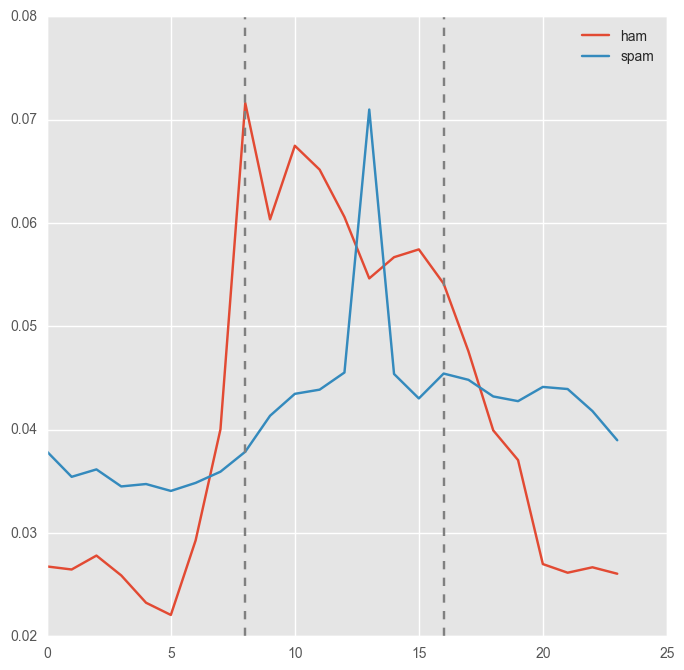

In [5]:
hour_count = []
hour  = ['00','01','02','03','04','05','06','07','08','09','10','11',
         '12','13','14','15','16','17','18','19','20','21','22','23']
for i in hour :
          c=collections.Counter(data[data['Hour']==i]['Classification'])
          hour_count.append(c)
hour_count = pd.DataFrame(hour_count,index=hour)



fig = plt.figure(figsize=[8,8])
line1, = plt.plot(hour_count['ham']/sum(hour_count['ham']), label='ham')
line2, = plt.plot(hour_count['spam']/sum(hour_count['spam']), label='spam')
plt.axvline(x=8,c='gray',linestyle='dashed')
plt.axvline(x=16,c='gray',linestyle='dashed')
plt.legend()
plt.savefig("Ham_and_Spam_per_hour.png")
plt.show()

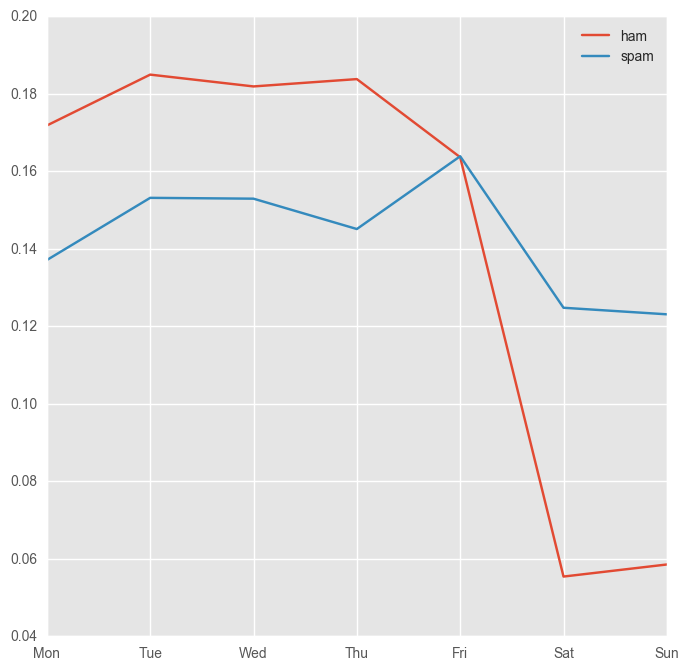

In [6]:
wd_count = []
wd  = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
for i in wd :
          c=collections.Counter(data[data['Weekday']==i]['Classification'])
          wd_count.append(c)
wd_count = pd.DataFrame(wd_count,index=range(7))

fig = plt.figure(figsize=[8,8])
line1, = plt.plot(wd_count['ham']/sum(wd_count['ham']), label='ham')
line2, = plt.plot(wd_count['spam']/sum(wd_count['spam']), label='spam')
plt.xticks(range(7),wd)
plt.legend()
plt.savefig("Ham_and_Spam_weekday.png")
plt.show()

### Feature Engineering

In [7]:
#tfidf(original,bi,tri)
count = CountVectorizer(ngram_range=(1,1),stop_words='english',analyzer='word')
#count_bi = CountVectorizer(ngram_range=(1,2),stop_words='english',analyzer='word')
#count_tri = CountVectorizer(ngram_range=(1,3),stop_words='english',analyzer='word')

X_train_counts = count.fit_transform(train['Content'])
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
tfidf_transformer = TfidfTransformer()

X_train_tf = tf_transformer.transform(X_train_counts)
X_test_counts = count.transform(test['Content'])
X_test_tf = tf_transformer.transform(X_test_counts)

c = collections.Counter()
c.update(data['Classification'])
pd.DataFrame({'ham': c['ham'],'spam':c['spam']},index=[0])

,ham,spam
0,60951,98930


In [8]:
#1:spam; 0:ham
y_train = train['Classification']
y_train  = (y_train  == 'spam')*1
y_test = test['Classification']
y_test = (y_test  == 'spam')*1

### Data Reduction (SVD/LSA)

- Reduce Tfidf matrix to dim=100 LSA matrix

In [9]:
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
from sklearn.preprocessing import Normalizer
lsa = TruncatedSVD(100, algorithm = 'arpack')
dtm_lsa = lsa.fit_transform(X_train_tf)
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)

dtm_lsa_test = lsa.transform(X_test_tf)
dtm_lsa_test = Normalizer(copy=False).transform(dtm_lsa_test)

###  Decision Tree

In [10]:
from sklearn.tree import DecisionTreeClassifier

In [11]:
start_time = time.time()
text_clf = Pipeline([('lsa', TruncatedSVD(100, algorithm = 'arpack')),
                     ('clf', DecisionTreeClassifier(max_depth=10))])
_ = text_clf.fit(X_train_tf,y_train)
predicted = text_clf.predict(X_test_tf)
confuseM = confusion_matrix(predicted, y_test)
print "Running time is {}".format(time.time()-start_time)

Running time is 78.2405939102


In [12]:
confuseM

array([[16474,  1269],
       [ 1847, 28375]])

In [13]:
np.mean(predicted == y_test)

0.93503596372354847

In [14]:
start_time = time.time()
text_clf = Pipeline([('lsa', TruncatedSVD(100, algorithm = 'arpack')),
                     ('clf', DecisionTreeClassifier(max_depth=20))])
_ = text_clf.fit(X_train_tf,y_train)
predicted = text_clf.predict(X_test_tf)
confuseM = confusion_matrix(predicted, y_test)
print "Running time is {}".format(time.time()-start_time)

Running time is 81.1206099987


In [15]:
confuseM 

array([[16837,  1167],
       [ 1484, 28477]])

In [16]:
np.mean(predicted == y_test) ### best

0.94473053268007923

In [17]:
start_time = time.time()
text_clf = Pipeline([('lsa', TruncatedSVD(100, algorithm = 'arpack')),
                     ('clf', DecisionTreeClassifier(max_depth=50))])
_ = text_clf.fit(X_train_tf,y_train)
predicted = text_clf.predict(X_test_tf)
confuseM = confusion_matrix(predicted, y_test)
print "Running time is {}".format(time.time()-start_time)

Running time is 84.1060259342


In [18]:
confuseM 

array([[16907,  1325],
       [ 1414, 28319]])

In [19]:
np.mean(predicted == y_test)

0.94289586156572502

In [20]:
start_time = time.time()
text_clf = Pipeline([('lsa', TruncatedSVD(100, algorithm = 'arpack')),
                     ('clf', DecisionTreeClassifier())])
_ = text_clf.fit(X_train_tf,y_train)
predicted = text_clf.predict(X_test_tf)
confuseM = confusion_matrix(predicted, y_test)
print "Running time is {}".format(time.time()-start_time)

Running time is 85.103055954


In [21]:
confuseM 

array([[16886,  1333],
       [ 1435, 28311]])

In [22]:
np.mean(predicted == y_test)

0.94229125403940373

### KNN

In [23]:
from sklearn.neighbors import KNeighborsClassifier

In [24]:
start_time = time.time()
text_clf = Pipeline([('lsa', TruncatedSVD(100, algorithm = 'arpack')),
                     ('clf', KNeighborsClassifier(n_neighbors=3))])
_ = text_clf.fit(X_train_tf,y_train)
predicted = text_clf.predict(X_test_tf)
confuseM = confusion_matrix(predicted, y_test)
print "Running time is {}".format(time.time()-start_time)

Running time is 457.406303167


In [25]:
confuseM

array([[17331,   651],
       [  990, 28993]])

In [26]:
np.mean(predicted == y_test) ## best model

0.96578755342437195

In [27]:
start_time = time.time()
text_clf = Pipeline([('lsa', TruncatedSVD(100, algorithm = 'arpack')),
                     ('clf', KNeighborsClassifier(n_neighbors=5))])
_ = text_clf.fit(X_train_tf,y_train)
predicted = text_clf.predict(X_test_tf)
confuseM = confusion_matrix(predicted, y_test)
print "Running time is {}".format(time.time()-start_time)

Running time is 441.203185081


In [28]:
confuseM

array([[17241,   655],
       [ 1080, 28989]])

In [29]:
np.mean(predicted == y_test)

0.96382779109767536

In [30]:
start_time = time.time()
text_clf = Pipeline([('lsa', TruncatedSVD(100, algorithm = 'arpack')),
                     ('clf', KNeighborsClassifier(n_neighbors=7))])
_ = text_clf.fit(X_train_tf,y_train)
predicted = text_clf.predict(X_test_tf)
confuseM = confusion_matrix(predicted, y_test)
print "Running time is {}".format(time.time()-start_time)

Running time is 494.405426979


In [31]:
confuseM

array([[17125,   635],
       [ 1196, 29009]])

In [32]:
np.mean(predicted == y_test)

0.96182633170019805

### Bi-gram Decision Tree

In [33]:
#tfidf(original,bi,tri)
count_bi = CountVectorizer(ngram_range=(1,2),stop_words='english',analyzer='word')

X_train_counts_bi = count_bi.fit_transform(train['Content'])
tf_transformer_bi = TfidfTransformer(use_idf=False).fit(X_train_counts_bi)
tfidf_transformer_bi = TfidfTransformer()

X_train_tf_bi = tf_transformer_bi.transform(X_train_counts_bi)
X_test_counts_bi = count_bi.transform(test['Content'])
X_test_tf_bi = tf_transformer_bi.transform(X_test_counts_bi)

In [ ]:
# Decision Tree
start_time = time.time()
text_clf = Pipeline([('lsa', TruncatedSVD(100, algorithm = 'arpack')),
                     ('clf', DecisionTreeClassifier(max_depth=10))])
_ = text_clf.fit(X_train_tf_bi,y_train)
predicted = text_clf.predict(X_test_tf_bi)
print "Running time is {}".format(time.time()-start_time)

In [ ]:
confusion_matrix(predicted, y_test)

In [ ]:
np.mean(predicted == y_test)

In [ ]:
# Decision Tree
start_time = time.time()
text_clf = Pipeline([('lsa', TruncatedSVD(100, algorithm = 'arpack')),
                     ('clf', DecisionTreeClassifier(max_depth=20))])
_ = text_clf.fit(X_train_tf_bi,y_train)
predicted = text_clf.predict(X_test_tf_bi)
print "Running time is {}".format(time.time()-start_time)

In [ ]:
confusion_matrix(predicted, y_test)

In [ ]:
np.mean(predicted == y_test)

In [ ]:
# Decision Tree
start_time = time.time()
text_clf = Pipeline([('lsa', TruncatedSVD(100, algorithm = 'arpack')),
                     ('clf', DecisionTreeClassifier(max_depth=50))])
_ = text_clf.fit(X_train_tf_bi,y_train)
predicted = text_clf.predict(X_test_tf_bi)
print "Running time is {}".format(time.time()-start_time)

In [ ]:
confusion_matrix(predicted, y_test)

In [ ]:
np.mean(predicted == y_test)

In [ ]:
# Decision Tree
start_time = time.time()
text_clf = Pipeline([('lsa', TruncatedSVD(100, algorithm = 'arpack')),
                     ('clf', DecisionTreeClassifier())])
_ = text_clf.fit(X_train_tf_bi,y_train)
predicted = text_clf.predict(X_test_tf_bi)
print "Running time is {}".format(time.time()-start_time)

In [ ]:
confusion_matrix(predicted, y_test)

In [ ]:
np.mean(predicted == y_test)

### Bi-gram KNN

In [ ]:
# KNN
start = time.time()
text_clf = Pipeline([('lsa', TruncatedSVD(100, algorithm = 'arpack')),
                     ('clf', KNeighborsClassifier(n_neighbors=3))])
_ = text_clf.fit(X_train_tf_bi,y_train)
predicted = text_clf.predict(X_test_tf_bi)
print "Running time is {}".format(time.time()-start)

In [ ]:
confusion_matrix(predicted, y_test)

In [ ]:
np.mean(predicted == y_test)

In [ ]:
# KNN
start = time.time()
text_clf = Pipeline([('lsa', TruncatedSVD(100, algorithm = 'arpack')),
                     ('clf', KNeighborsClassifier(n_neighbors=5))])
_ = text_clf.fit(X_train_tf_bi,y_train)
predicted = text_clf.predict(X_test_tf_bi)
print "Running time is {}".format(time.time()-start)

In [ ]:
confusion_matrix(predicted, y_test)

In [ ]:
np.mean(predicted == y_test)

In [ ]:
# KNN
start = time.time()
text_clf = Pipeline([('lsa', TruncatedSVD(100, algorithm = 'arpack')),
                     ('clf', KNeighborsClassifier(n_neighbors= 7))])
_ = text_clf.fit(X_train_tf_bi,y_train)
predicted = text_clf.predict(X_test_tf_bi)
print "Running time is {}".format(time.time()-start)

In [ ]:
confusion_matrix(predicted, y_test)

In [ ]:
np.mean(predicted == y_test)